# Automatic Speech Recognition

Automatic speech recognition (ASR) is a commonly used machine learning (ML) technology in our daily lives and business scenarios. Applications such as voice-controlled assistants like `Alexa` and `Siri`, and voice-to-text applications like automatic subtitling for videos and transcribing meetings, are all powered by this technology. These applications take audio clips as input and convert speech signals to text, also referred to as speech-to-text applications.

The goal of this tutorial is to:

 * Introduce Wav2Vec2 for Automatic Speech Recognition
 * learn to write custom Forte processors for speech segmentation and recognition
 * Automatically transcribe text from an audio file, using Forte

Along the way, we will go through the Forte pipeline and learn how to integrate with other third-party libraries like `HuggingFace` and `Pyannote`.

Before looking at this tutorial, we first need to appreciate the broad scope of this topic.

## Wav2Vec2

[Wav2Vec2](https://arxiv.org/abs/2006.11477) is a transformer-based architecture for ASR tasks. The following diagram shows its simplified architecture. The model is composed of a multi-layer convolutional network (CNN) as a feature extractor, which takes an input audio signal and outputs audio representations. They are fed into a transformer network to generate contextualized representations. This part of training can be self-supervised; the transformer can be trained with unlabeled speech and learn from it. Then the model is fine-tuned on labeled data with the `Connectionist Temporal Classification` (CTC) algorithm for specific ASR tasks. The base model we use in this tutorial is [Wav2Vec2-Base-960h](https://huggingface.co/facebook/wav2vec2-base-960h), fine-tuned on 960 hours of `Librispeech` on 16 kHz sampled speech audio.
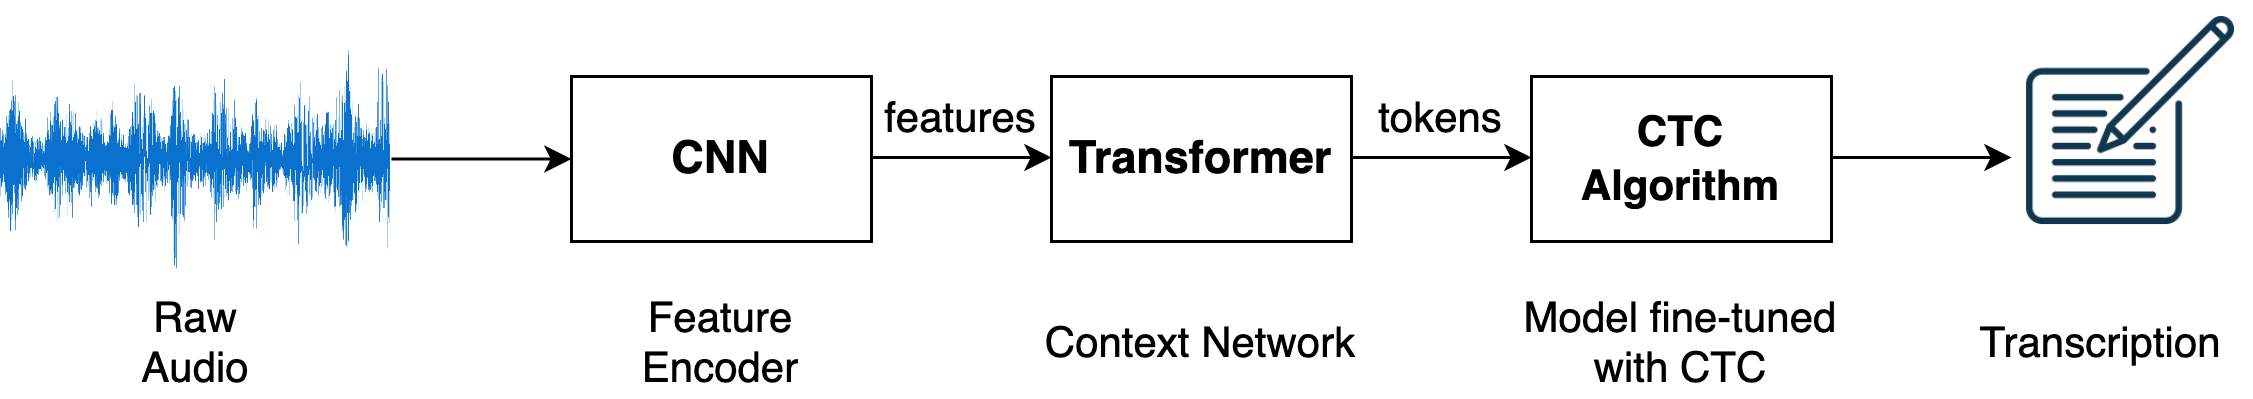

Let's try to load our sample audio file and listen to it.

In [1]:
import IPython
audio_path='../../examples/audio'
audio_file=audio_path +'/test_audio.wav'
IPython.display.Audio(audio_file)

You can click on the play button to listen to the audio. We can find that there are three speakers in the audio. Let's try to segment each speaker's audio utterance. To do this, we'll write a custom Forte Processor, which can use `Pyannote-Audio` pre-trained models.

In [2]:
import pyannote.audio
from forte.common.configuration import Config
from forte.common.resources import Resources
from forte.data.data_pack import DataPack
from forte.data.readers import AudioReader
from forte.processors.base.pack_processor import PackProcessor
from ft.onto.base_ontology import AudioUtterance, Utterance

In [3]:
class SpeakerSegmentationProcessor(PackProcessor):
    """
    An audio processor for speaker segmentation.
    """

    def initialize(self, resources: Resources, configs: Config):
        super().initialize(resources, configs)
        self._model = pyannote.audio.Pipeline.from_pretrained(
            "pyannote/speaker-segmentation"
        )

    def _process(self, input_pack: DataPack):
        output = self._model(input_pack.pack_name)
        for turn, _, speaker in output.itertracks(yield_label=True):
            audio_utter: AudioUtterance = AudioUtterance(
                pack=input_pack,
                begin=int(turn.start * input_pack.sample_rate),
                end=int(turn.end * input_pack.sample_rate)
            )
            audio_utter.speaker = speaker


Let's define the Forte pipeline for speaker segmentation.

In [4]:
from forte.pipeline import Pipeline
pipeline = Pipeline[DataPack]()
pipeline.set_reader(AudioReader(), config={"file_ext": ".wav"})
pipeline.add(SpeakerSegmentationProcessor())
pipeline.initialize();

In [5]:
seg=[]
for datapack in pipeline.process_dataset(audio_path):
    for pack in datapack.get(AudioUtterance):
        seg.append([datapack.sample_rate,pack.audio,pack.speaker])

The speaker segmentation model could detect four different segments.

In [6]:
len(seg)

4

In [7]:
def play_audio(i):
    print(i[2])
    return IPython.display.Audio(i[1], rate=i[0])

Let's go through the segments and verify the quality.

In [8]:
play_audio(seg[0])

SPEAKER_00


In [9]:
play_audio(seg[1])

SPEAKER_01


In [10]:
play_audio(seg[2])

SPEAKER_00


In [11]:
play_audio(seg[3])

SPEAKER_02


We can find that the `pyannote` speaker segmentation has split our audio file into four sub-segments with unique speaker identification. The third segment is an error output from the model. But the overall quality of segments is pretty good.
Now let's write another custom processor to use the pre-trained `facebook/wav2vec2-base-960h` speech-to-text model from [HuggingFace](https://huggingface.co/facebook/wav2vec2-base-960h).

In [12]:
from torch import argmax
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from forte.common.exception import ProcessFlowException
from forte.processors.base.pack_processor import PackProcessor
from forte.data.ontology.top import Link

In [13]:
class AudioUtteranceASRProcessor(PackProcessor):
    """
    An audio processor for automatic speech recognition.
    """

    def initialize(self, resources: Resources, configs: Config):
        super().initialize(resources, configs)

        # Initialize tokenizer and model
        pretrained_model: str = "facebook/wav2vec2-base-960h"
        self._tokenizer = Wav2Vec2Processor.from_pretrained(pretrained_model)
        self._model = Wav2Vec2ForCTC.from_pretrained(pretrained_model)

    def _process(self, input_pack: DataPack):
        required_sample_rate: int = 16000
        if input_pack.sample_rate != required_sample_rate:
            raise ProcessFlowException(
                f"A sample rate of {required_sample_rate} Hz is requied by the"
                " pretrained model."
            )

        for audio_utter in input_pack.get(AudioUtterance):

            # tokenize
            input_values = self._tokenizer(
                audio_utter.audio, return_tensors="pt", padding="longest"
            ).input_values  # Batch size 1

            # take argmax and decode
            transcription = self._tokenizer.batch_decode(
                argmax(self._model(input_values).logits, dim=-1)
            )

            if not transcription[0]:
                continue

            input_pack.set_text(text=input_pack.text + transcription[0])

            # Create annotations on audio and text utterance
            text_utter: Utterance = Utterance(
                pack=input_pack,
                begin=len(input_pack.text) - len(transcription[0]),
                end=len(input_pack.text)
            )
            text_utter.speaker = audio_utter.speaker
            Link(pack=input_pack, parent=audio_utter, child=text_utter)

lets add the AudioUtteranceASRProcessor to our pipeline.

In [14]:
pipeline.add(AudioUtteranceASRProcessor())
pipeline.initialize();

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
seg=[]
for pack in pipeline.process_dataset(audio_path):
    for asr_link in pack.get(Link):
        audio_utter = asr_link.get_parent()
        text_utter = asr_link.get_child()
        seg.append([pack.sample_rate,audio_utter.audio,text_utter.speaker,text_utter.text])

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Let's verify the quality of speech 

In [16]:
def verify_speech_to_text(i):
    print(i[2],' : ',i[3])
    return IPython.display.Audio(i[1], rate=i[0])

In [17]:
verify_speech_to_text(seg[0])

SPEAKER_00  :  IMG CUFVERADGE CONTINUES NOW WITH OUR THER POLITICAL REPORTE MICHAEL DOUBT N


In [18]:
verify_speech_to_text(seg[1])

SPEAKER_01  :  HE JOINS US LIFE FROM THE ALLERT CENTER WITH WHAT VOTERS THINK OF TO NIGHT'S DEBATE MICHAEL


In [19]:
verify_speech_to_text(seg[2])

SPEAKER_02  :  EL WITH MAINLY REHASHED ARGUMENTS HERE ALMOST EVERY ON THE PANEL FELT THEY COULD HAVE USED A LITTLE LESS POLITICS AS USUAL BUT ON WHO WON THE DEBATE WHILE OUR PANEL WAS SPLIT ON PRETTY MUCH PARTY LINES


Although the speech-to-text output is not perfect, it's doing a good job getting most of the words correct. You can try on your audio recordings and play with this tutorial.